### The correlates of crackling

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from frites.conn.conn_tf import _tf_decomp
from frites.stats import confidence_interval
from frites.utils import parallel_func
from mne.filter import filter_data
from mne.stats import fdr_correction
from tqdm import tqdm
from config import freqs

from config import get_dates, return_delay_split, return_evt_dt
from GDa.loader import loader
from GDa.session import session
from GDa.stats.bursting import find_start_end

In [3]:
def hilbert_spectra(
    data, fsample, freqs, bandwidth, n_jobs=1, verbose=False, kw_filter={}
):
    """
    Compute the Hilbert spectra of a 3D data array.

    Parameters:
    - data (xr.DataArray): Input data array with dimensions ("trials", "roi", "time").
    - fsample (float): Sampling frequency of the data.
    - freqs (array-like): Center frequencies for the spectral analysis.
    - bandwidth (float): Half-width of the frequency bands.
    - n_jobs (int, optional): Number of parallel jobs to run for filtering. Default is 1.
    - verbose (bool, optional): If True, print verbose messages during filtering. Default is False.
    - kw_filter (dict, optional): Additional keyword arguments for the `filter_data` function.

    Returns:
    - xr.DataArray: Hilbert spectra of the input data, with dimensions ("trials", "roi", "freqs", "times").

    Note:
    The input data is filtered into frequency bands centered at the specified frequencies with the given bandwidth.
    The Hilbert transform is then applied to obtain the analytic signal, and the squared magnitude of the analytic
    signal is computed to obtain the Hilbert spectra.

    The resulting DataArray has dimensions representing trials, regions of interest (ROIs), frequency bins, and time points.
    """

    from mne.filter import filter_data

    assert isinstance(data, xr.DataArray)

    dims = data.dims
    coords = data.coords
    attrs = data.attrs

    np.testing.assert_array_equal(dims, ("trials", "roi", "time"))

    lfreqs = np.clip(freqs - bandwidth, 0, np.inf)
    hfreqs = freqs + bandwidth

    bands = np.stack((lfreqs, hfreqs), axis=1)

    data_filtered = []
    for lf, hf in bands:
        data_filtered += [
            filter_data(
                data.values,
                fsample,
                lf,
                hf,
                n_jobs=n_jobs,
                **kw_filter,
                verbose=verbose
            )
        ]
    data_filtered = np.stack(data_filtered, axis=1)
    hilbert = scipy.signal.hilbert(data_filtered, axis=-1)
    sxx = hilbert * np.conj(hilbert)

    sxx = xr.DataArray(
        sxx.real,
        dims=("trials", "freqs", "roi", "times"),
        coords=(coords["trials"], freqs, coords["roi"], coords["time"]),
    ).transpose("trials", "roi", "freqs", "times")

    sxx.attrs = attrs

    return sxx

#### Setting configurations

In [4]:
_ROOT = os.path.expanduser("~/funcog/gda/")
metric = "coh"
monkey = "lucy"

In [5]:
sessions = get_dates(monkey)

In [6]:
evt_dt = return_evt_dt("cue", monkey)
stages = [[-0.5, -0.2], [0, 0.4], [0.5, 0.9], [0.9, 1.3], [1.1, 1.5]]
stage_labels = ["P", "S", "D1", "D2", "Dm"]

In [7]:
data_loader = loader(_ROOT=_ROOT)

#### Loading LFP, unities and power

In [8]:
# Window in which the data will be read
evt_dt = return_evt_dt("cue", monkey=monkey)
# Path to LFP data
raw_path = os.path.expanduser("~/funcog/gda/GrayLab/")
# Instantiate class
ses = session(
    raw_path=raw_path,
    monkey=monkey,
    date="141017",
    session=1,
    slvr_msmod=True,
    align_to="cue",
    evt_dt=evt_dt,
)

# Read LFP
ses.read_from_mat()
LFP = ses.filter_trials(trial_type=[1], behavioral_response=[1])

roi_channel = [f"{r} ({c})" for r, c in zip(LFP.roi.data, LFP.attrs["channels_labels"])]
LFP = LFP.assign_coords({"roi": roi_channel})

# Read SPIKES
ses.read_from_mat(load_spike_times=True)
SPIKES = ses.spike_times.sel(trials=LFP.trials)

(595, 94, 3650)


In [9]:
SPIKES = SPIKES.assign_coords({"roi": roi_channel})

In [10]:
kw_loader = dict(
    session="141017",
    aligned_at="cue",
    channel_numbers=True,
    monkey=monkey,
    decim=5,
    mode="hilbert",
)

POWER = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1).sel(
    times=slice(-0.5, 2)
)

ZPOWER = (POWER - POWER.mean("times")) / POWER.std("times")

In [11]:
kw_loader = dict(
    session="141017",
    aligned_at="cue",
    channel_numbers=True,
    monkey=monkey,
    decim=5,
    mode="morlet",
)

POWER2 = data_loader.load_power(**kw_loader, trial_type=1, behavioral_response=1).sel(
    times=slice(-0.5, 2)
)

ZPOWER2 = (POWER - POWER.mean("times")) / POWER.std("times")

#### Raw LFP for these channels in units of microvolts

- V1 - chn 219
- V6A - chn 183
- a5 - chn 149
- a3 - chn 106
- F1 - chn 73
- 8r - chn 22
- 9/46d - chn 9

#### Filtered LFP for the same channels in the following bands in units of microvolts (no normalization so we can compare the relative amplitudes across channels)

- 1-10 Hz
- 5-15 Hz
- 10-30 Hz
- 20-50 Hz

In [12]:
rois = [
    "V1 (219)",
    "V6A (183)",
    "a5 (149)",
    "a3 (106)",
    "F1 (73)",
    "a8r (22)",
    "a9/46D (9)",
]

In [13]:
LFP.values = LFP.values * 1e6

In [14]:
f_low = np.clip(freqs - 4, 1, np.inf)
f_high = np.clip(freqs + 4, 0, np.inf)

bands = np.stack((f_low, f_high), axis=1)
print(bands)

[[ 1.  7.]
 [ 7. 15.]
 [15. 23.]
 [23. 31.]
 [31. 39.]
 [39. 47.]
 [47. 55.]
 [55. 63.]
 [63. 71.]
 [71. 79.]]


In [15]:
print(freqs)

[ 3. 11. 19. 27. 35. 43. 51. 59. 67. 75.]


In [16]:
LFP = LFP.sel(roi=rois)

In [17]:
FILTERED_LFP = []

for f_low, f_high in bands:

    FILTERED_LFP += [filter_data(LFP.data, LFP.fsample, f_low, f_high, n_jobs=10)]

Setting up band-pass filter from 1 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 446 tasks      | elapsed:    1.2s


Setting up band-pass filter from 7 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 1651 samples (1.651 s)



[Parallel(n_jobs=10)]: Done 2000 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 2324 out of 2324 | elapsed:    1.4s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 758 tasks      | elapsed:    0.1s


Setting up band-pass filter from 15 - 23 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 23.00 Hz
- Upper transition bandwidth: 5.75 Hz (-6 dB cutoff frequency: 25.88 Hz)
- Filter length: 881 samples (0.881 s)



[Parallel(n_jobs=10)]: Done 2090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 2324 out of 2324 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 758 tasks      | elapsed:    0.1s


Setting up band-pass filter from 23 - 31 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 23.00
- Lower transition bandwidth: 5.75 Hz (-6 dB cutoff frequency: 20.12 Hz)
- Upper passband edge: 31.00 Hz
- Upper transition bandwidth: 7.75 Hz (-6 dB cutoff frequency: 34.88 Hz)
- Filter length: 575 samples (0.575 s)



[Parallel(n_jobs=10)]: Done 2090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 2324 out of 2324 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 758 tasks      | elapsed:    0.1s


Setting up band-pass filter from 31 - 39 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 31.00
- Lower transition bandwidth: 7.75 Hz (-6 dB cutoff frequency: 27.12 Hz)
- Upper passband edge: 39.00 Hz
- Upper transition bandwidth: 9.75 Hz (-6 dB cutoff frequency: 43.88 Hz)
- Filter length: 427 samples (0.427 s)



[Parallel(n_jobs=10)]: Done 2090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 2324 out of 2324 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 758 tasks      | elapsed:    0.1s


Setting up band-pass filter from 39 - 47 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 39.00
- Lower transition bandwidth: 9.75 Hz (-6 dB cutoff frequency: 34.12 Hz)
- Upper passband edge: 47.00 Hz
- Upper transition bandwidth: 11.75 Hz (-6 dB cutoff frequency: 52.88 Hz)
- Filter length: 339 samples (0.339 s)



[Parallel(n_jobs=10)]: Done 2090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 2324 out of 2324 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 758 tasks      | elapsed:    0.1s


Setting up band-pass filter from 47 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 47.00
- Lower transition bandwidth: 11.75 Hz (-6 dB cutoff frequency: 41.12 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 281 samples (0.281 s)



[Parallel(n_jobs=10)]: Done 2090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 2324 out of 2324 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 758 tasks      | elapsed:    0.1s


Setting up band-pass filter from 55 - 63 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 55.00
- Lower transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 48.12 Hz)
- Upper passband edge: 63.00 Hz
- Upper transition bandwidth: 15.75 Hz (-6 dB cutoff frequency: 70.88 Hz)
- Filter length: 241 samples (0.241 s)



[Parallel(n_jobs=10)]: Done 2090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 2324 out of 2324 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 758 tasks      | elapsed:    0.1s


Setting up band-pass filter from 63 - 71 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 63.00
- Lower transition bandwidth: 15.75 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Upper passband edge: 71.00 Hz
- Upper transition bandwidth: 17.75 Hz (-6 dB cutoff frequency: 79.88 Hz)
- Filter length: 211 samples (0.211 s)



[Parallel(n_jobs=10)]: Done 2090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 2324 out of 2324 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 758 tasks      | elapsed:    0.1s


Setting up band-pass filter from 71 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 71.00
- Lower transition bandwidth: 17.75 Hz (-6 dB cutoff frequency: 62.12 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 19.75 Hz (-6 dB cutoff frequency: 88.88 Hz)
- Filter length: 187 samples (0.187 s)



[Parallel(n_jobs=10)]: Done 2090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 2324 out of 2324 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 758 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 2090 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 2324 out of 2324 | elapsed:    0.2s finished


In [18]:
band_centers = freqs.astype(int)

In [19]:
FILTERED_LFP = xr.DataArray(
    FILTERED_LFP,
    dims=("freqs", "trials", "roi", "time"),
    coords=(band_centers, LFP.trials, rois, LFP.time),
)

In [20]:
REF_TRIAL = 249

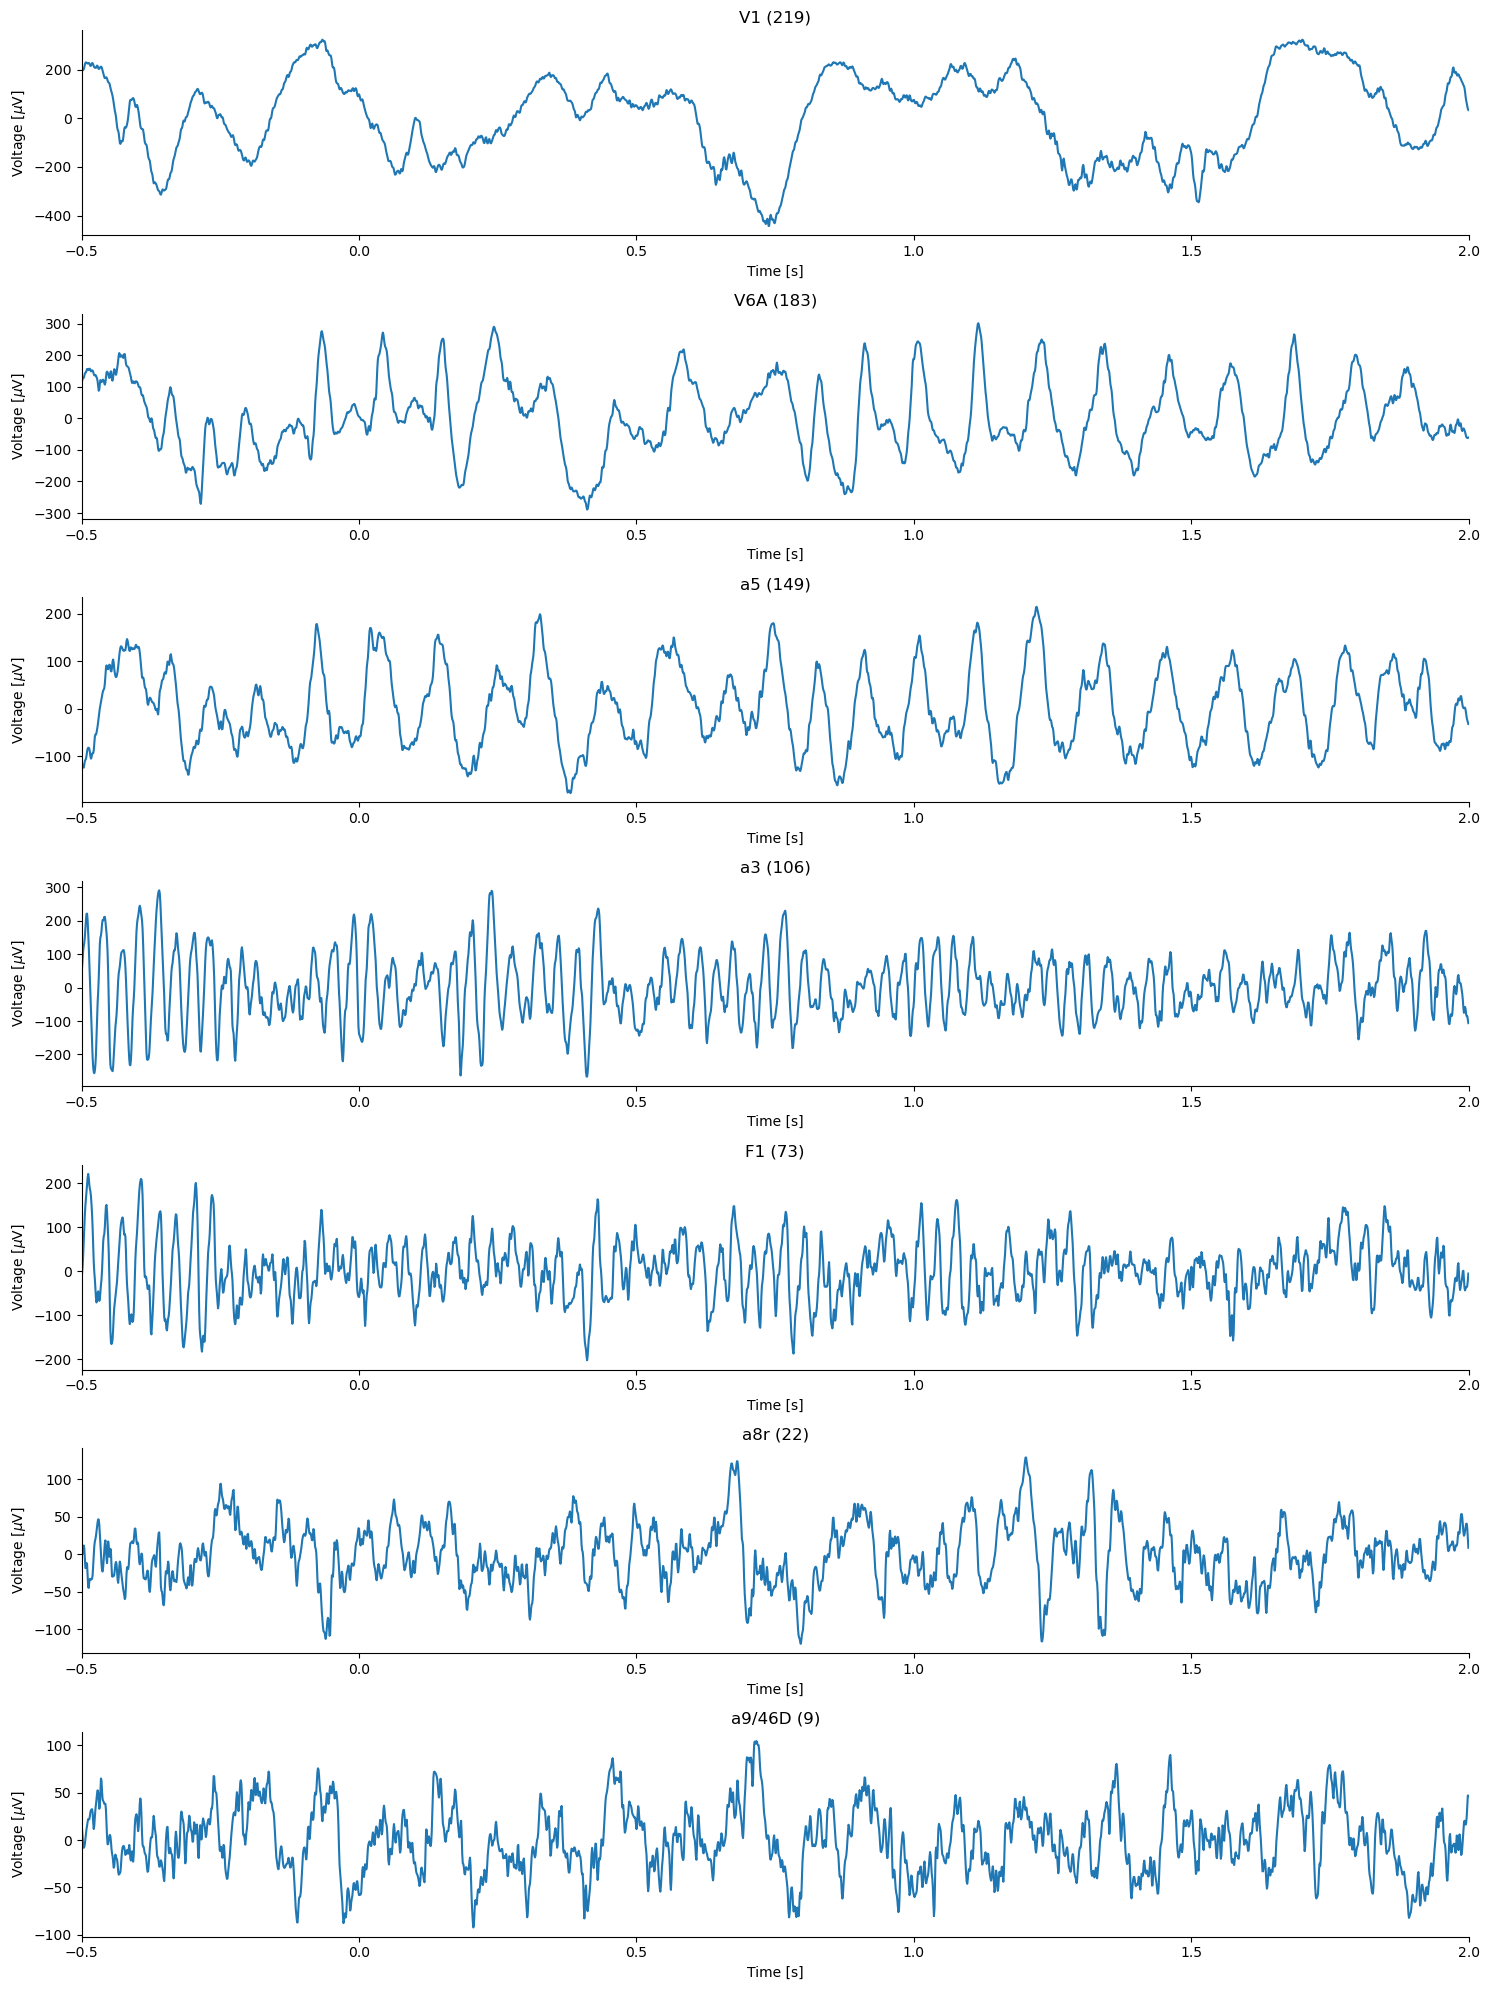

In [35]:
plt.figure(figsize=(15, 20))
pos = 1
for i in range(len(rois)):
    ax = plt.subplot(len(rois), 1, pos)
    LFP.sel(roi=rois, trials=REF_TRIAL, time=slice(-0.5, 2)).isel(roi=i).plot()
    pos += 1
    plt.title(f"{rois[i]}")
    plt.xlabel("Time [s]")
    plt.ylabel(r"Voltage [$\mu$V]")
    plt.xlim(-0.5, 2)
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.tight_layout()
plt.savefig(f"charlie_figures/raw_lfps_{REF_TRIAL + 1}.png")

In [22]:
for freq in range(len(bands)):
    plt.figure(figsize=(15, 20))
    pos = 1
    for i in range(len(rois)):
        ax = plt.subplot(len(rois), 1, pos)
        FILTERED_LFP.sel(roi=rois, trials=REF_TRIAL, time=slice(-0.5, 2)).isel(
            roi=i, freqs=freq
        ).plot()
        pos += 1
        plt.title(f"{rois[i]}")
        plt.xlabel("Time [s]")
        plt.ylabel(r"Voltage [$\mu$V]")
        plt.xlim(-0.5, 2)
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]

    plt.tight_layout()
    plt.savefig(
        f"charlie_figures/filtered_lfps_center_freq_{band_centers[freq]}_{REF_TRIAL + 1}.png"
    )
    plt.close()

In [23]:
hilbert = ZPOWER.sel(roi=rois)
morlet = ZPOWER2.sel(roi=rois)

In [24]:
for freq in range(len(bands)):
    plt.figure(figsize=(15, 20))
    pos = 1
    for i in range(len(rois)):
        ax = plt.subplot(len(rois), 1, pos)
        FILTERED_LFP.sel(roi=rois, trials=REF_TRIAL, time=slice(-0.5, 2)).isel(roi=i, freqs=freq).plot()
        pos += 1
        plt.title(f"{rois[i]}")
        plt.xlabel("Time [s]")
        plt.ylabel(r"Voltage [$\mu$V]")
        plt.xlim(-0.5, 2)
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
        
    plt.tight_layout()
    plt.savefig(f"charlie_figures/filtered_lfps_center_freq_{band_centers[freq]}_{REF_TRIAL + 1}.png")
    plt.close()

In [25]:
for freq in range(len(bands)):
    plt.figure(figsize=(15, 20))
    pos = 1
    for i in range(len(rois)):
        ax = plt.subplot(len(rois), 1, pos)
        FILTERED_LFP.sel(roi=rois, trials=REF_TRIAL, time=slice(-0.5, 2)).isel(
            roi=i, freqs=freq
        ).plot(label="Filtered LFP")
        ((100 / (freq + 1)) * morlet).sel(roi=rois, trials=REF_TRIAL, times=slice(-0.5, 2)).isel(
            roi=i, freqs=freq
        ).plot(label="Morlet", c="k")
        ((100 / (freq + 1)) * hilbert).sel(roi=rois, trials=REF_TRIAL, times=slice(-0.5, 2)).isel(
            roi=i, freqs=freq
        ).plot(ls="--", label="Hilbert", c="r")
        if i == 0:
            plt.legend()
        pos += 1
        plt.title(f"{rois[i]}")
        plt.xlabel("Time [s]")
        plt.ylabel(r"Voltage [$\mu$V]")
        plt.xlim(-0.5, 2)
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.tight_layout()
    plt.savefig(
        f"charlie_figures/power_time_series_center_freq_{band_centers[freq]}_{REF_TRIAL + 1}.png"
    )
    plt.close()

In [124]:
CRACKLES_1SIG = morlet >= morlet.quantile(.50, "times")
CRACKLES_2SIG = morlet >= morlet.quantile(.75, "times")
CRACKLES_3SIG = morlet >= morlet.quantile(.90, "times")

In [131]:
for freq in range(len(bands)):
    plt.figure(figsize=(15, 20))
    pos = 1
    for i in range(len(rois)):
        ax = plt.subplot(len(rois), 1, pos)
        x1 = (
            CRACKLES_1SIG.sel(roi=rois, trials=REF_TRIAL, times=slice(-0.5, 2))
            .isel(roi=i, freqs=freq)
            .astype(float)
        )
        x2 = (
            CRACKLES_2SIG.sel(roi=rois, trials=REF_TRIAL, times=slice(-0.5, 2))
            .isel(roi=i, freqs=freq)
            .astype(float)
        )
        x3 = (
            CRACKLES_3SIG.sel(roi=rois, trials=REF_TRIAL, times=slice(-0.5, 2))
            .isel(roi=i, freqs=freq)
            .astype(float)
        )
        y = FILTERED_LFP.sel(roi=rois, trials=REF_TRIAL, time=slice(-0.5, 2)).isel(
            roi=i, freqs=freq
        )
        ((100 / (freq + 1)) * morlet).sel(
            roi=rois, trials=REF_TRIAL, times=slice(-0.5, 2)
        ).isel(roi=i, freqs=freq).plot(c="g")
        x1[x1 == 0] = np.nan
        x2[x2 == 0] = np.nan
        x3[x3 == 0] = np.nan
        (x1 * y.max() + 2).plot(c="k", lw="5")
        (x2 * y.max() + 40).plot(c="green", lw="5")
        (x3 * y.max() + 80).plot(c="r", lw="5")
        y.plot()
        pos += 1
        plt.title(f"{rois[i]}")
        plt.xlabel("Time [s]")
        plt.ylabel(r"Voltage [$\mu$V]")
        plt.xlim(-0.5, 2)
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.tight_layout()
    plt.savefig(
        f"charlie_figures/relative_crackles_center_freq_{band_centers[freq]}_{REF_TRIAL + 1}.png"
    )
    plt.close()

In [132]:
CRACKLES_1SIG_global = morlet >= morlet.quantile(.50, ("times", "trials"))
CRACKLES_2SIG_global = morlet >= morlet.quantile(.75, ("times", "trials"))
CRACKLES_3SIG_global = morlet >= morlet.quantile(.90, ("times", "trials"))

In [133]:
for freq in range(len(bands)):
    plt.figure(figsize=(15, 20))
    pos = 1
    for i in range(len(rois)):
        ax = plt.subplot(len(rois), 1, pos)
        x1 = (
            CRACKLES_1SIG_global.sel(roi=rois, trials=REF_TRIAL, times=slice(-0.5, 2))
            .isel(roi=i, freqs=freq)
            .astype(float)
        )
        x2 = (
            CRACKLES_2SIG_global.sel(roi=rois, trials=REF_TRIAL, times=slice(-0.5, 2))
            .isel(roi=i, freqs=freq)
            .astype(float)
        )
        x3 = (
            CRACKLES_3SIG_global.sel(roi=rois, trials=REF_TRIAL, times=slice(-0.5, 2))
            .isel(roi=i, freqs=freq)
            .astype(float)
        )
        y = FILTERED_LFP.sel(roi=rois, trials=REF_TRIAL, time=slice(-0.5, 2)).isel(
            roi=i, freqs=freq
        )
        ((100 / (freq + 1)) * morlet).sel(
            roi=rois, trials=REF_TRIAL, times=slice(-0.5, 2)
        ).isel(roi=i, freqs=freq).plot(c="g")
        x1[x1 == 0] = np.nan
        x2[x2 == 0] = np.nan
        x3[x3 == 0] = np.nan
        (x1 * y.max() + 2).plot(c="k", lw="5")
        (x2 * y.max() + 40).plot(c="green", lw="5")
        (x3 * y.max() + 80).plot(c="r", lw="5")
        y.plot()
        pos += 1
        plt.title(f"{rois[i]}")
        plt.xlabel("Time [s]")
        plt.ylabel(r"Voltage [$\mu$V]")
        plt.xlim(-0.5, 2)
        [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.tight_layout()
    plt.savefig(
        f"charlie_figures/absolute_crackles_center_freq_{band_centers[freq]}_{REF_TRIAL + 1}.png"
    )
    plt.close()

In [21]:
from frites.conn import define_windows

In [50]:
win, twin = define_windows(FILTERED_LFP.time.data, slwin_len=20 / 1000 )

Defining temporal windows (sfreq=999.9999999999991)
    Definition of sliding windows (len=0.02, start=-0.65, stop=2.999000000000003, step=0.021)


In [51]:
rms = []
for wi, wf in win:
    out = np.sqrt(
        (
            FILTERED_LFP.sel(roi="a5 (149)", freqs=35).isel(time=slice(wi, wf)) ** 2
            / 20
        ).sum("time")
    )
    rms += [out]

In [52]:
rms = xr.concat(rms, "times")
rms = rms.assign_coords({"times": twin}).sel(times=slice(-.5, 2))

In [53]:
rms = (rms - rms.mean("times")) / rms.std("times")

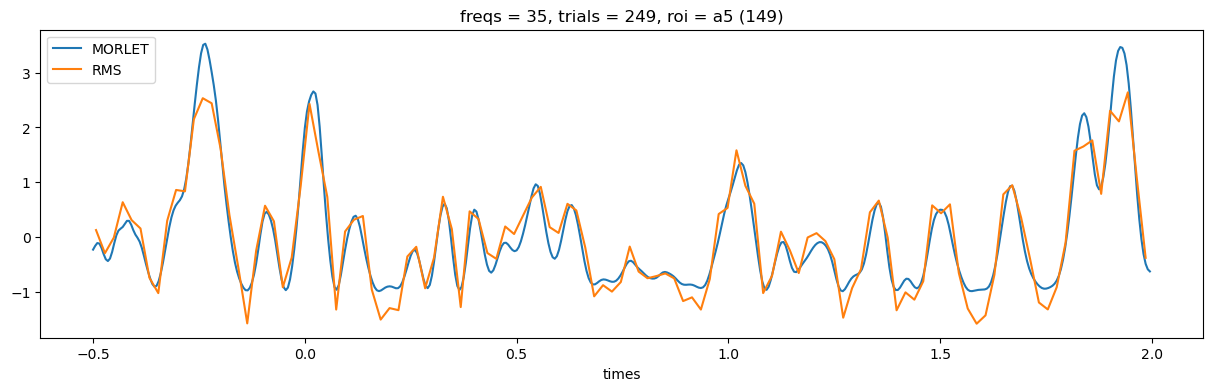

In [54]:
plt.figure(figsize=(15, 4))
ZPOWER2.sel(roi="a5 (149)", freqs=35, trials=REF_TRIAL).plot(label="MORLET")
rms.sel(trials=REF_TRIAL).plot(label="RMS")
plt.legend()

In [56]:
20 / 1000 * 1000

20.0

In [48]:
import jax
import jax.numpy as jnp

def outer_product(v):
    return np.outer(v, v)

# Vectorize the outer_product function using jax.vmap
vectorized_outer_product = jax.vmap(outer_product, in_axes=1, out_axes=0)

In [64]:
vec = ZPOWER2.sel(freqs=27, trials=4, times=slice(.5, .9)).data.T

In [68]:
out = np.array([outer_product(vec[i]) for i in range(len(vec))]).mean(0)

In [81]:
np.fill_diagonal(out, 0)

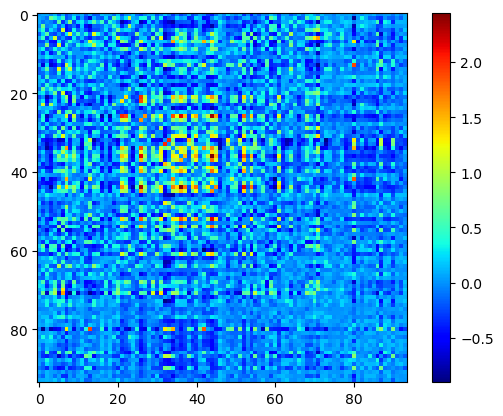

In [82]:
plt.imshow(out, cmap="jet")
plt.colorbar()

In [ ]:
import numpy as np
from numpy.random import default_rng
rng = default_rng(42)  # Create a random number generator

from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix

from gtda.graphs import GraphGeodesicDistance
from gtda.homology import VietorisRipsPersistence, SparseRipsPersistence, FlagserPersistence

from igraph import Graph

from IPython.display import SVG, display

X = [out]

# Instantiate topological transformer
VR = VietorisRipsPersistence(metric="precomputed", homology_dimensions=[0, 1, 2, 3, 4], )

# Compute persistence diagrams corresponding to each entry (only one here) in X
diagrams = VR.fit_transform(X)

print(f"diagrams.shape: {diagrams.shape} ({diagrams.shape[1]} topological features)")

In [116]:
diagrams.squeeze()

array([[ 0.        ,  0.        ,  0.        ],
       [-0.09324849, -0.08921277,  1.        ],
       [-0.0974679 , -0.07322259,  1.        ],
       ...,
       [-0.30580068, -0.01827262,  2.        ],
       [-0.30596998,  0.01502258,  2.        ],
       [-0.31277284, -0.03918745,  2.        ]])

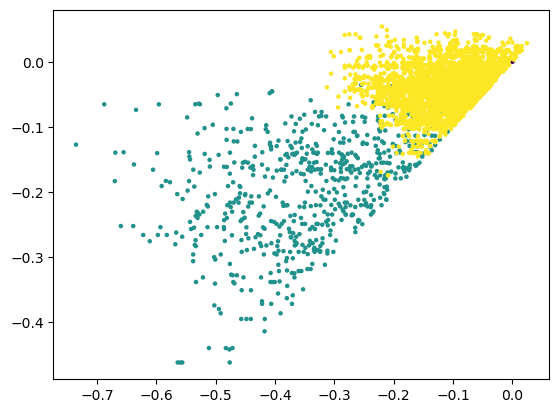

In [120]:
plt.scatter(diagrams[0, :, 0], diagrams[0, :, 1], c=diagrams[0, :, 2], s=5)

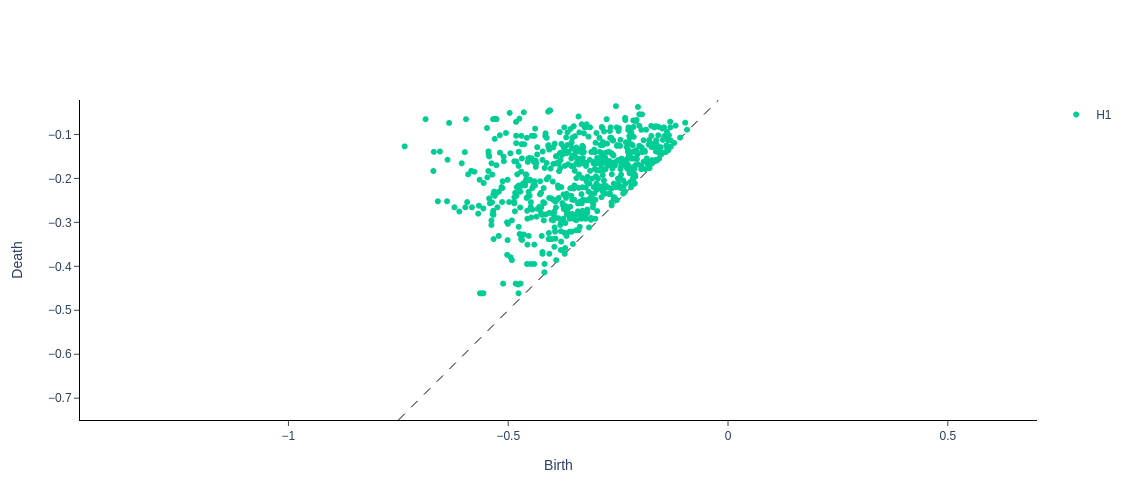

In [86]:


from gtda.plotting import plot_diagram

plot_diagram(diagrams[0])

In [77]:
diagrams.shape

(1, 641, 3)

In [25]:
thr = ZPOWER.quantile(.95, ("times"))

In [23]:
CRACKLES = ZPOWER2 >= thr

In [17]:
LFP_FILTERED = filter_data(LFP.data, 1000, 25, 40)
LFP_FILTERED = xr.DataArray(LFP_FILTERED, dims=LFP.dims, coords=LFP.coords)

Setting up band-pass filter from 25 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (0.529 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 31208 out of 31208 | elapsed:   19.2s finished


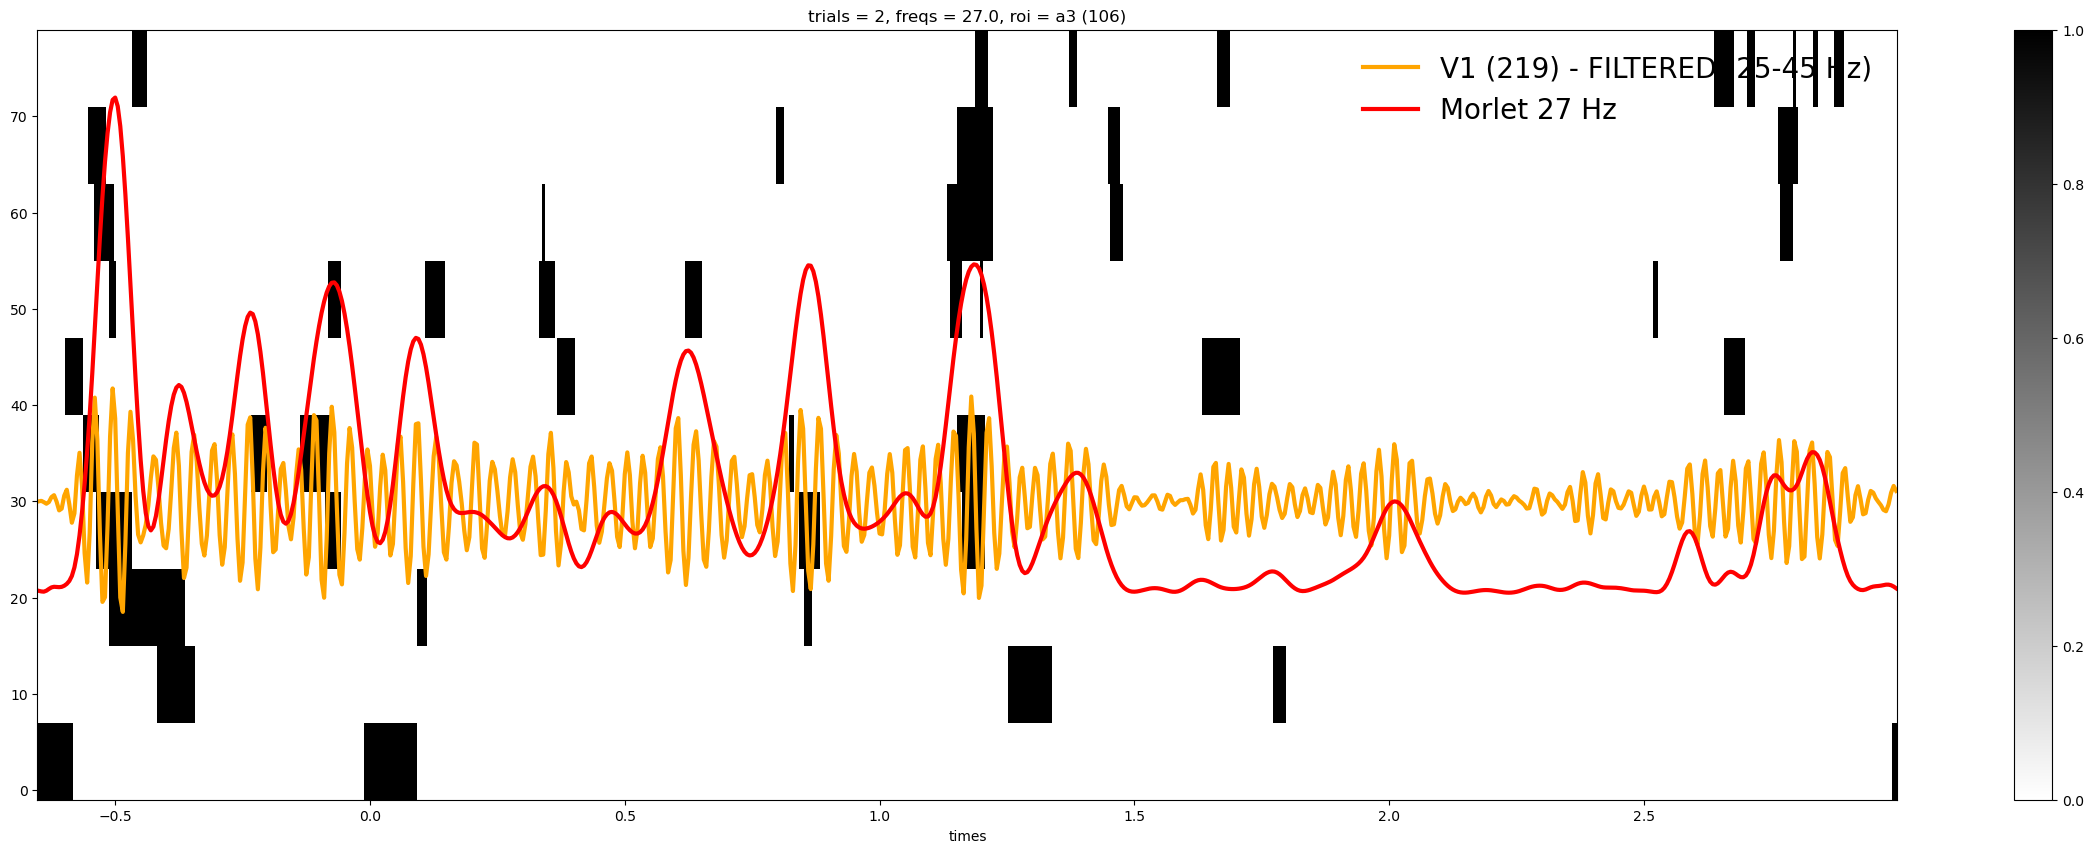

In [21]:
plt.figure(figsize=(30, 10))
CRACKLES.sel(roi="a3 (106)").isel(trials=0).plot(cmap="binary")
((LFP_FILTERED.sel(roi="a3 (106)")[0][..., ::5] * 5e4 + 30)).plot(lw=3, c="orange", label="V1 (219) - FILTERED (25-45 Hz)")
((ZPOWER2.sel(roi="a3 (106)", freqs=27)[0] * 10 + 30)).plot(lw=3, c="r", label="Morlet 27 Hz")
plt.legend(fontsize=20, frameon=False)
plt.savefig("superimposed.pdf")

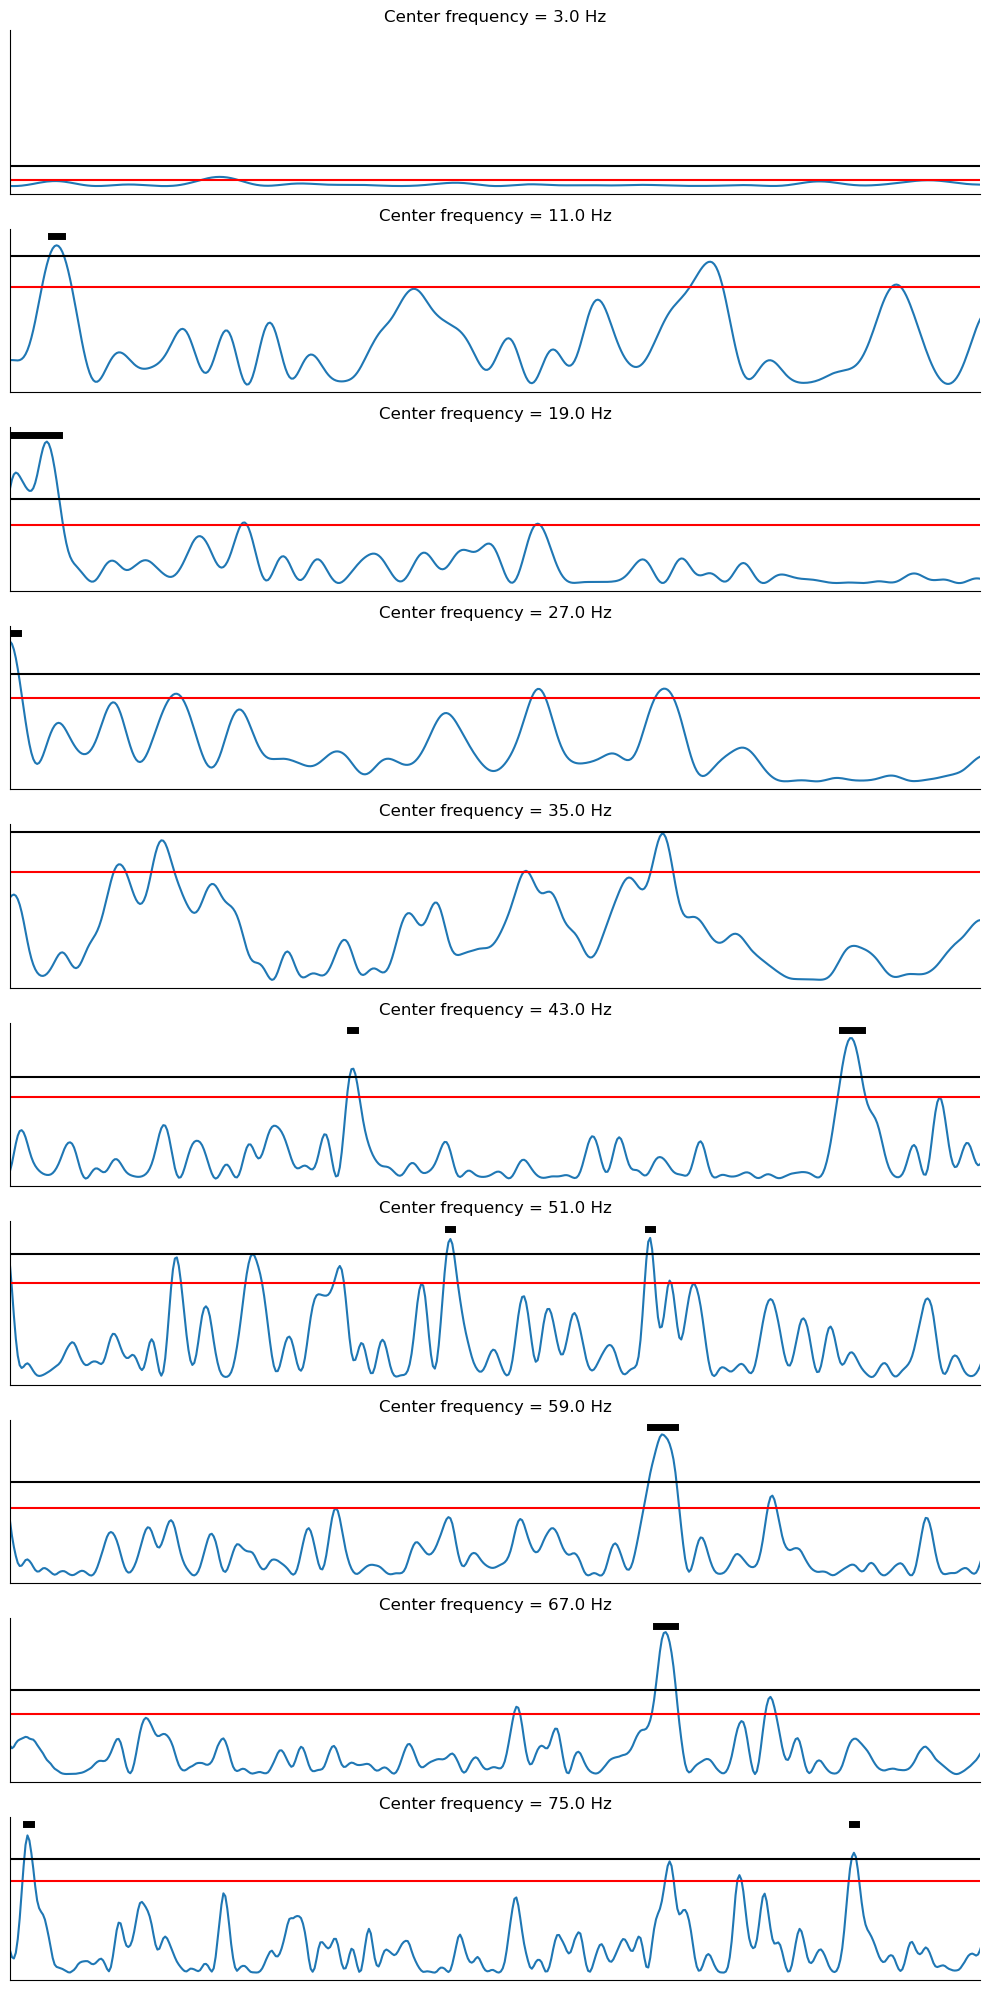

In [30]:
plt.figure(figsize=(10, 20))

# CRACKLES = ZPOWER2 >= 1

for pos, freq in enumerate(ZPOWER.freqs.data):
    ax = plt.subplot(10, 1, pos + 1)
    x = CRACKLES.sel(roi="a3 (106)", freqs=freq)[0].astype(float)
    y = ZPOWER2.sel(roi="a3 (106)", freqs=freq)[0]
    x[x == 0] = np.nan
    (x * y.max() + 0.3).plot(c="k", lw="5")
    y.plot()
    plt.hlines(thr.sel(roi="a3 (106)", freqs=freq)[0], -0.6, 3, "r")
    plt.hlines(3, -0.6, 3, "k")

    plt.xlim(-0.5, 2)
    plt.xticks([])
    plt.yticks([])
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.title(f"Center frequency = {freq} Hz")
    plt.xlabel("")
plt.tight_layout()
plt.savefig("crackles.pdf")

In [316]:
CRACKLES = ZPOWER2 >= 1
x = CRACKLES.sel(freqs=27, trials=4).sum("roi")

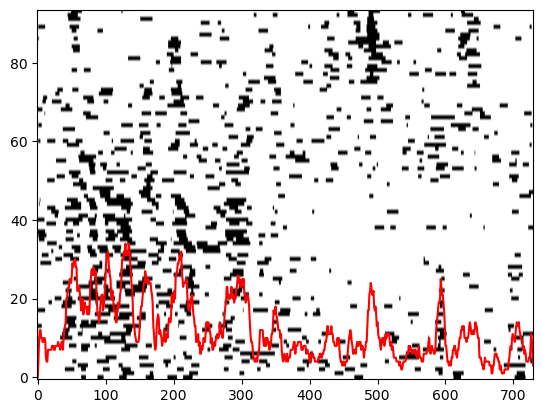

In [318]:
plt.imshow(CRACKLES.sel(freqs=27, trials=4), aspect="auto", cmap="binary", origin="lower")
plt.plot(x, "r")

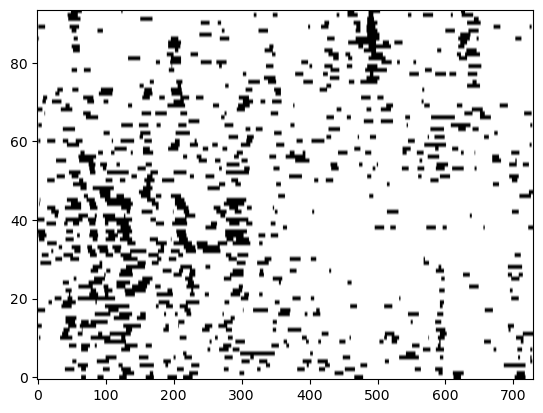

In [373]:
plt.imshow(CRACKLES.sel(freqs=27, trials=4), aspect="auto", cmap="binary", origin="lower")
thr = x > x.quantile(.7)

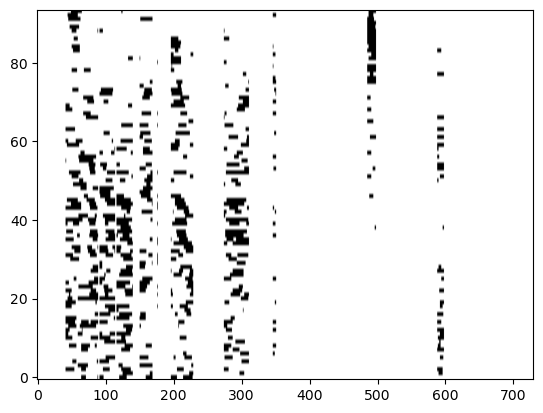

In [381]:
plt.imshow(CRACKLES.sel(freqs=27, trials=4) * thr, aspect="auto", cmap="binary", origin="lower")

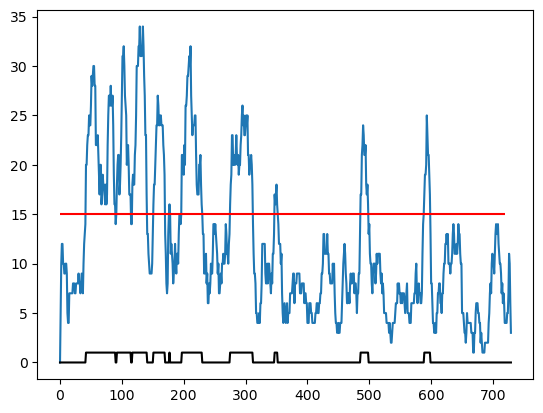

In [372]:
plt.plot(x)
plt.hlines(x.quantile(.7), 0, 720, "r")
plt.plot(x > x.quantile(.7), "k")

In [322]:
find_start_end( (x > x.quantile(.7)).data )

array([[ 42,  90],
       [ 92, 115],
       [117, 141],
       [151, 170],
       [177, 178],
       [197, 230],
       [275, 312],
       [347, 352],
       [486, 499],
       [589, 599]])

In [354]:
A = CRACKLES.sel(freqs=27, trials=4).isel(times=slice(117, 141))

In [355]:
import jax

In [356]:
import jax
import jax.numpy as jnp

# Define your function that computes the outer product of a vector with itself
def outer_product(v):
    return jnp.outer(v, v)

# Vectorize the outer_product function using jax.vmap
vectorized_outer_product = jax.vmap(outer_product, in_axes=1, out_axes=0)

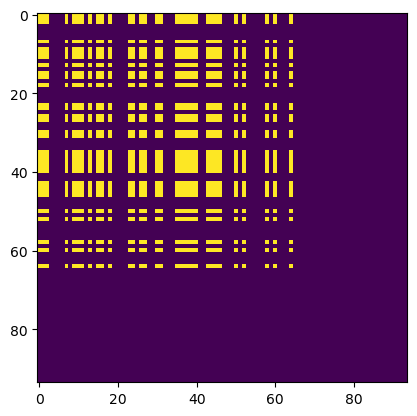

In [366]:
plt.imshow(  np.outer(A[:, 10].data, A[:, 10].data) )

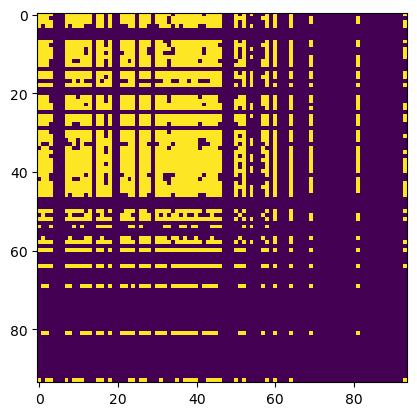

In [367]:
plt.imshow( vectorized_outer_product(A.data).sum(axis=0) > 0 )

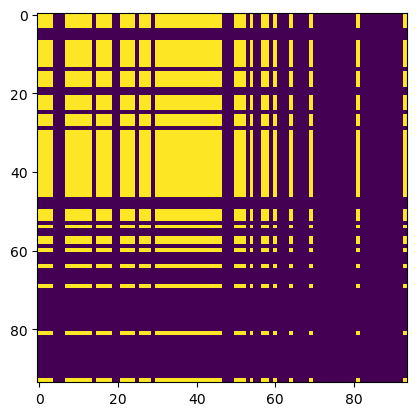

In [369]:
plt.imshow(  np.outer(A.sum(axis=1).data, A.sum(axis=1).data) > 0 )

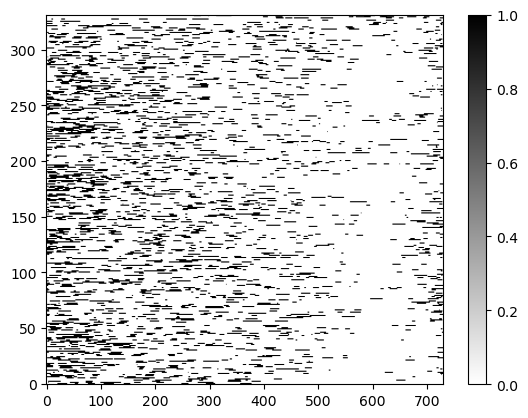

In [284]:
plt.imshow( CRACKLES.sel(roi="a3 (106)", freqs=27), cmap="binary", origin="lower", aspect="auto" )
plt.colorbar()

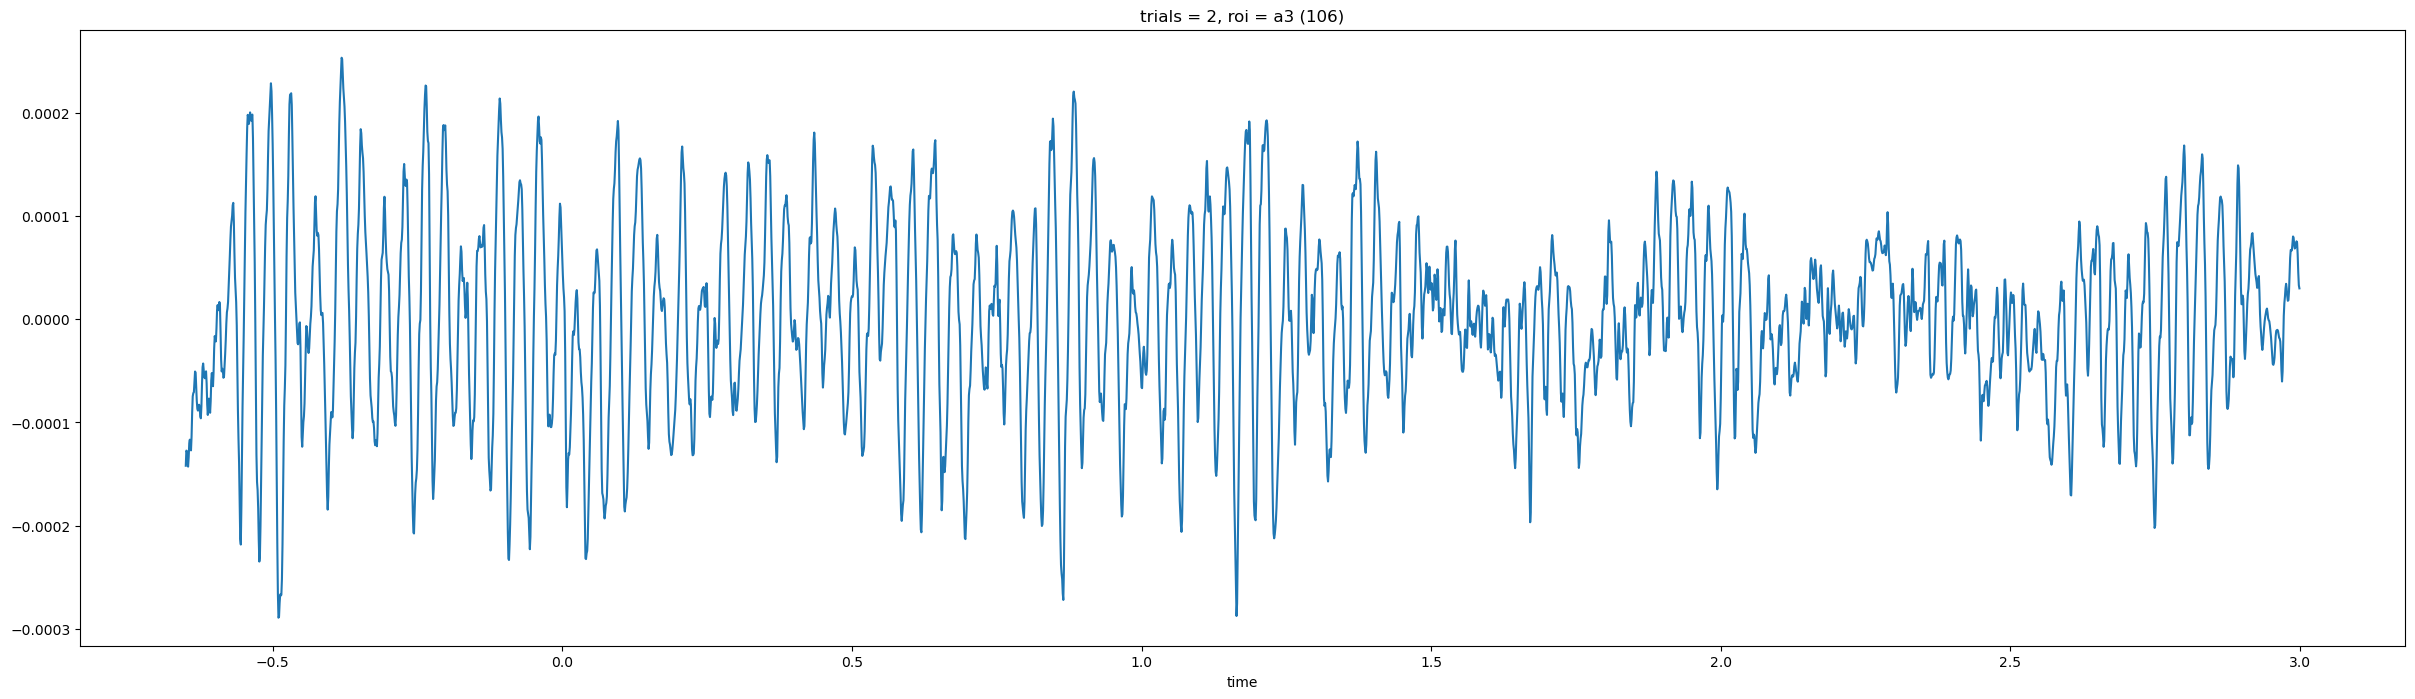

In [153]:
plt.figure(figsize=(30, 8))
LFP.sel(roi="a3 (106)")[0].plot()

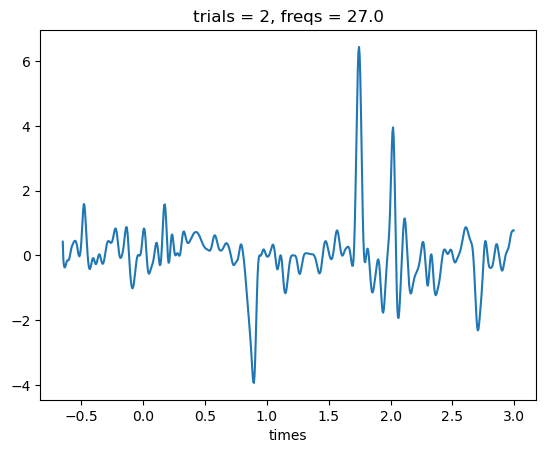

In [188]:
x = ZPOWER.isel(roi=0, trials=0, freqs=3) 
y = ZPOWER.isel(roi=30, trials=0, freqs=3)

(x * y).plot()


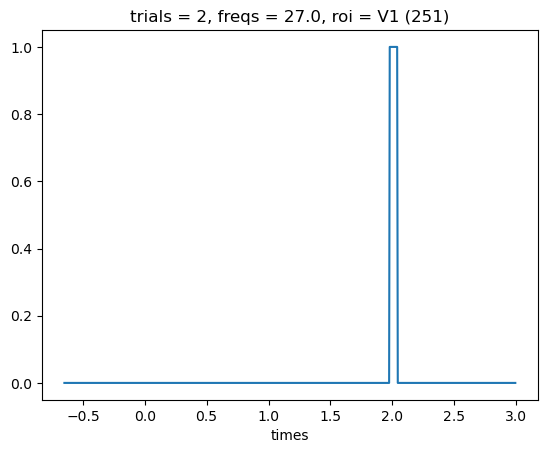

In [181]:
( y >= 3 ).plot()

In [71]:
def triggered_avg(
    data=None,
    spikes=None,
    low_pass=None,
    high_pass=None,
    win_size=None,
    verbose=False,
    decim=None,
):

    n_trials, n_roi, n_times = data.shape
    roi = data.roi.data

    # High-pass filtered data
    data_hp = filter_data(
        data.data, data.fsample, l_freq=low_pass, h_freq=high_pass, verbose=verbose
    )
    # Converts back to DataArray
    data_hp = xr.DataArray(data_hp, dims=data.dims, coords=data.coords)
    """
    data_hp = (data_hp - data_hp.mean(("trials", "time"))) / data_hp.std(
        ("trials", "time")
    )
    """

    if isinstance(decim, int):
        data_hp = data_hp[..., ::decim]
        n_times = data_hp.sizes["time"]

    # win_size = int(win_size * data.fsample)

    data_hp = data_hp.data.swapaxes(0, 1).reshape(n_roi, n_trials * n_times)
    spikes = spikes.data.reshape(n_roi, n_trials * n_times)

    def _for_roi(i):
        peaks = find_start_end(spikes[i]).mean(1).astype(int)
        snipets = np.zeros((len(peaks), 2 * win_size))
        for pidx, idx in enumerate(peaks):
            temp = data_hp[i, (idx - win_size) : (idx + win_size)]
            if len(temp) == 2 * win_size:
                snipets[pidx, :] = temp
        return (
            confidence_interval(snipets, axis=0, verbose=False).squeeze().T
        )  # snipets.mean(0)

    snipets = np.stack([_for_roi(i) for i in range(n_roi)])
    print(snipets.shape)
    times = np.linspace(-win_size, win_size, snipets.shape[1])
    snipets = xr.DataArray(
        snipets,
        dims=("roi", "times", "bounds"),
        coords=(
            roi,
            times,
            ["lower", "higher"],
        ),
    )

    return snipets

In [115]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)

In [124]:
y = LFP 

CTA = []
nCTA = []

for freq in [27]:

    x = CRACKLES.sel(freqs=freq)

    out = triggered_avg(
        data=SPIKES_CV,
        spikes=x,
        low_pass=1,
        high_pass=250,
        win_size=20,
        decim=5,
        verbose=False,
    )

    x_SHUFFLE = x.copy()
    x_SHUFFLE.values = shuffle_along_axis(x.data, 1)
    
    out1 = triggered_avg(
        data=SPIKES_CV,
        spikes=x_SHUFFLE,
        low_pass=1,
        high_pass=250,
        win_size=20,
        decim=5,
        verbose=False,
    )
    
    CTA += [out]
    nCTA += [out1]

(94, 40, 2)
(94, 40, 2)


In [118]:
CTA = xr.concat(CTA, "freqs").assign_coords({"freqs": [27]})
nCTA = xr.concat(nCTA, "freqs").assign_coords({"freqs": [27]})

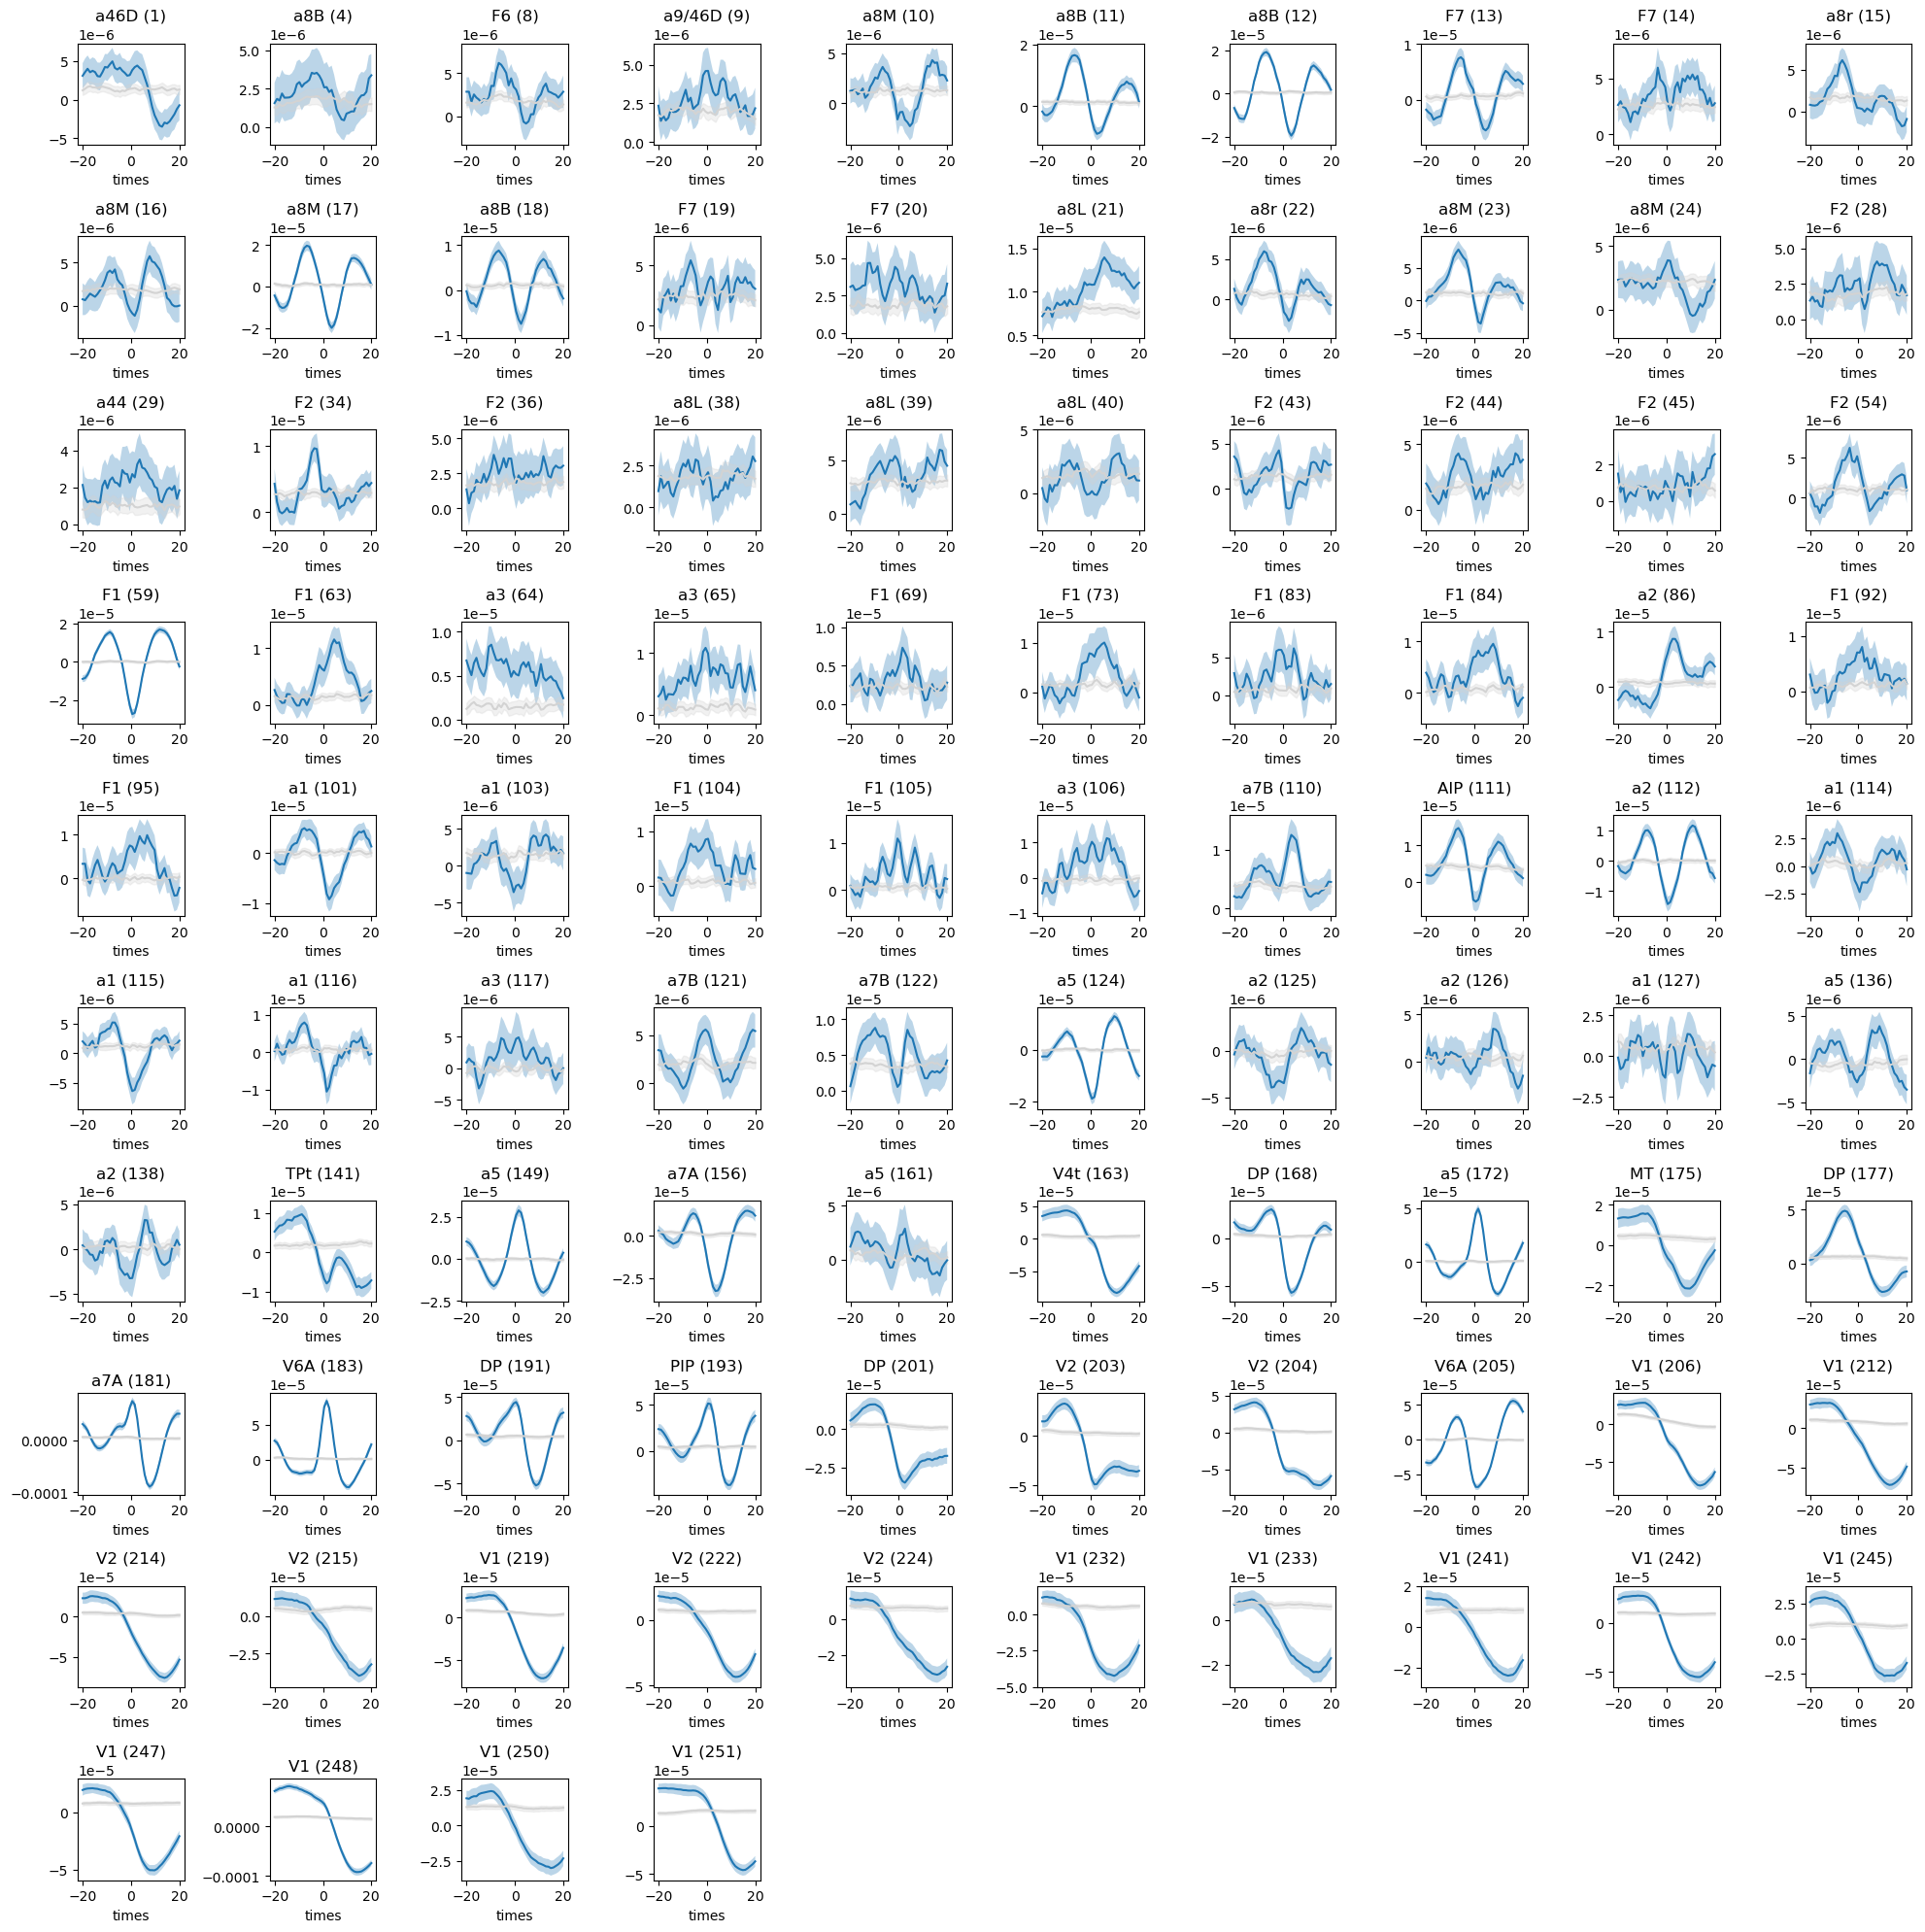

In [122]:
plt.figure(figsize=(20, 20))
unique_rois = np.unique(out.roi.data)
for pos, r in enumerate(out.roi[:100].data):
    plt.subplot(10, 10, pos + 1)
    # Original
    CTA.sel(roi=r, freqs=27).median("bounds").plot()
    plt.fill_between(
        CTA.times,
        CTA.sel(roi=r, freqs=27, bounds="lower"),
        CTA.sel(roi=r, freqs=27, bounds="higher"),
        alpha=0.3,
    )
    # Surrogate
    nCTA.sel(roi=r, freqs=27).median("bounds").plot(c="lightgray")
    plt.fill_between(
        nCTA.times,
        nCTA.sel(roi=r, freqs=27, bounds="lower"),
        nCTA.sel(roi=r, freqs=27, bounds="higher"),
        alpha=0.3,
        color="lightgray"
    )
    plt.title(r)
plt.tight_layout()
plt.savefig("crackle_triggered_average.png")

In [80]:
kernel = np.hanning(100)

In [81]:
SPIKES_CV = scipy.signal.fftconvolve(SPIKES, kernel[None, None, :], axes=2, mode="same")

In [82]:
SPIKES_CV = xr.DataArray(SPIKES_CV, dims=SPIKES.dims, coords=SPIKES.coords)

In [86]:
SPIKES_CV.attrs["fsample"] = 1000

In [459]:
freq = 27

In [460]:
def z_score(data, dim="times"):
    return (data - data.mean(dim)) / data.std(dim)

thr = 1

kw_loader = dict(
    session="141024", aligned_at="cue", channel_numbers=False,
    monkey=monkey, decim=5
)

power = data_loader.load_power(
    **kw_loader, trial_type=1, behavioral_response=1
).sel(freqs=freq, times=slice(-0.5, 2))

times_array = power.times.data
trials_array = power.trials.data
rois = power.roi.data
attrs = power.attrs

# dt
dt = np.diff(times_array)[0]


# z-score power
power = z_score(power)
power.attrs = attrs

# Binarize power
raster = power >= thr
# Summed activity
rho = raster.sum("roi")

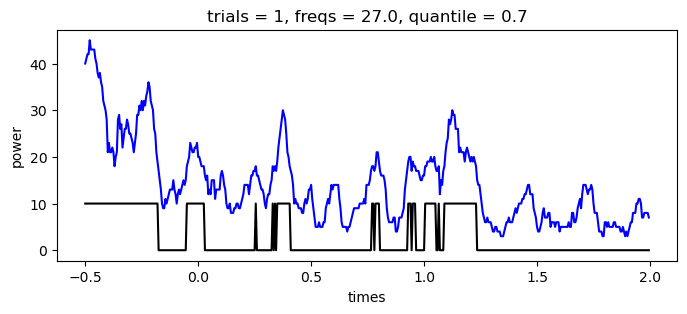

In [461]:
plt.figure(figsize=(8, 3))
(rho ).isel(trials=0).plot(c="b")
((rho > rho.quantile(.7, "times")) * 10).isel(trials=0).plot(c="k")

In [488]:
def find_start_end(array, find_zeros=False):
    """
    Given a binary array find the indexes where the sequences of ones start
    and begin if find_zeros is False. Otherwise it will find the indexes where
    the sequences of zeros start and begin. For instance, for the array
    [0,1,1,1,0,0], would return 1 and 3 respectively for find_zeros=False,
    and 1 and 2 for find_zeros=True.

    Parameters
    ----------
    array: array_like
        Binary array.
    find_zeros: bool | False
        Wheter to find a sequence of zeros or ones

    Returns
    -------
    The matrix containing the start anb ending index
    for each sequence of consecutive ones or zeros with shapes [n_seqs,2]
    where n_seqs is the number of sequences found.
    """
    if find_zeros:
        _bounds = np.array([1])
    else:
        _bounds = np.array([0])

    bounded = np.hstack((_bounds, array, _bounds))
    difs = np.diff(bounded)
    # get 1 at run starts and -1 at run ends if find_zeros is False
    if not find_zeros:
        run_starts, = np.where(difs > 0)
        run_ends, = np.where(difs < 0)
    # get -1 at run starts and 1 at run ends if find_zeros is True
    else:
        run_starts, = np.where(difs < 0)
        run_ends, = np.where(difs > 0)
    return np.vstack((run_starts, run_ends)).T

vectorized_find_start_end = jax.vmap(find_start_end, in_axes=0, out_axes=1)

In [489]:
mask = (rho > rho.quantile(.7, "times"))

In [524]:
stim = power.attrs["stim"]

In [540]:
cc_graphlet = []
trials_array = []
stim_array = []
for trial in tqdm(range(raster.sizes["trials"])):
    x = find_start_end(mask.isel(trials=trial).data)
    y = raster.isel(trials=trial)
    for ti, tf in x:
        temp = vectorized_outer_product(y.isel(times=slice(ti, tf)).data).mean(axis=0)
        cc_graphlet += [
            xr.DataArray(temp, dims=("sources", "targets"), coords=(rois, rois))
        ]
        trials_array += [trial]
        stim_array = [stim[trial]]
    
cc_graphlet = xr.concat(cc_graphlet, "trials").assign_coords({"trials": trials_array})
cc_graphlet.attrs["stim"] = stim_array

100%|███████████████████████████████████████████████████████| 582/582 [00:17<00:00, 34.15it/s]


In [553]:
a = cc_graphlet.sel(trials=20).mean("trials")

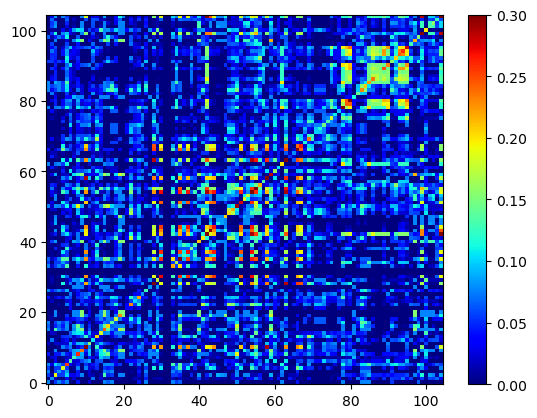

In [554]:
plt.imshow(a, aspect="auto", cmap="jet", origin="lower", vmax=.3)
plt.colorbar()

In [502]:
vectorized_outer_product( y.isel(times=slice(x[0, 0], x[0, 1])).data ).sum(axis=0)

Array([[11, 11,  0, ...,  0,  0,  0],
       [11, 17,  0, ...,  0,  0,  0],
       [ 0,  0, 28, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int32)

In [483]:
np.outer(A[:, 10].data, A[:, 10].data)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

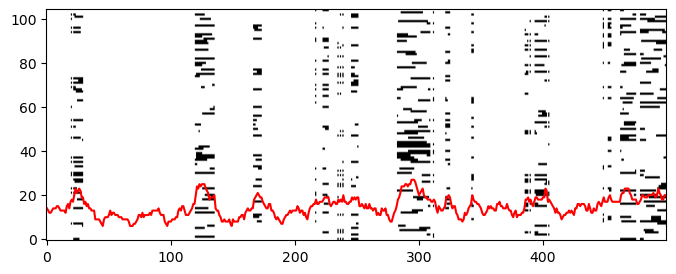

In [452]:
plt.figure(figsize=(8, 3))

plt.imshow(
    (raster * (rho > rho.quantile(0.7, "times"))).isel(trials=0),
    cmap="binary",
    aspect="auto",
    origin="lower",
)
plt.plot(rho.isel(trials=0), "r")

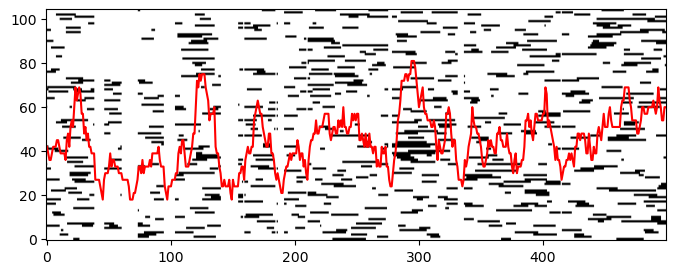

In [435]:
plt.figure(figsize=(8, 3))

plt.imshow(
    raster.isel(trials=0) * (rho.sel(times=slice(-0.5, 2)).isel(trials=0) > 9),
    cmap="binary",
    origin="lower",
    aspect="auto",
)
plt.plot(rho.isel(trials=0) * 3, "r")